Eric Verdú

# TFG


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

## Data Preprocessing

In [2]:
# Define the start date
start_date = '2017-01-01'

In [3]:
# Load Bitcoin data
bitcoin_data = pd.read_csv('Bitcoin.csv')

In [4]:
print(bitcoin_data.head())

                        time    open    high     low   close
0  2016-02-23T01:00:00+01:00  438.26  440.00  414.00  419.10
1  2016-02-24T01:00:00+01:00  419.10  424.28  409.07  423.78
2  2016-02-25T01:00:00+01:00  423.79  426.75  415.79  423.51
3  2016-02-26T01:00:00+01:00  423.38  432.00  418.01  432.00
4  2016-02-27T01:00:00+01:00  432.00  435.00  428.22  431.07


In [5]:
# Modify date
bitcoin_data['time'] = pd.to_datetime(bitcoin_data['time'], utc=True) # pd.to_datetime converts the 'time' column to datetime objects, we also convert the timestamps to UTC
bitcoin_data['time'] = bitcoin_data['time'].dt.tz_convert(None)   # dt.tz_convert(None) removes the timezone
bitcoin_data['time'] = bitcoin_data['time'].dt.floor('D')   # dt.floor('D') sets the time part to 00:00:00

In [6]:
print(bitcoin_data.head())

        time    open    high     low   close
0 2016-02-23  438.26  440.00  414.00  419.10
1 2016-02-24  419.10  424.28  409.07  423.78
2 2016-02-25  423.79  426.75  415.79  423.51
3 2016-02-26  423.38  432.00  418.01  432.00
4 2016-02-27  432.00  435.00  428.22  431.07


In [7]:
# Set date as index
bitcoin_data.set_index('time', inplace=True)

In [8]:
print(bitcoin_data.head())

              open    high     low   close
time                                      
2016-02-23  438.26  440.00  414.00  419.10
2016-02-24  419.10  424.28  409.07  423.78
2016-02-25  423.79  426.75  415.79  423.51
2016-02-26  423.38  432.00  418.01  432.00
2016-02-27  432.00  435.00  428.22  431.07


In [9]:
# Select close column
bitcoin_data = bitcoin_data[['close']]  # We will only use the 'close' column as as it represents the final price at the end of a given period and reflects all information and events that happened during that period

In [10]:
print(bitcoin_data.head())

             close
time              
2016-02-23  419.10
2016-02-24  423.78
2016-02-25  423.51
2016-02-26  432.00
2016-02-27  431.07


In [11]:
# Now let's select the starting date onwards for the data
bitcoin_data = bitcoin_data[bitcoin_data.index >= pd.to_datetime(start_date)]

In [12]:
print(bitcoin_data.head())

              close
time               
2017-01-01   997.75
2017-01-02  1012.54
2017-01-03  1035.24
2017-01-04  1114.92
2017-01-05  1004.74


In [13]:
bitcoin_data = bitcoin_data.rename(columns={'close': 'bitcoin'})

In [14]:
print(bitcoin_data.head())

            bitcoin
time               
2017-01-01   997.75
2017-01-02  1012.54
2017-01-03  1035.24
2017-01-04  1114.92
2017-01-05  1004.74


In [15]:
# Load factor data and merge it into the Bitcoin data
factors = ['Bonds2YR.csv', 'CentralBanks_Liquidity.csv', 'FED_Liquidity.csv', 'Gold.csv',
           'NASDAQ.csv', 'S&P500.csv', 'TIPS.csv', 'USDollar.csv', 'USPS.csv', 'VVIX.csv',
           'CPI.csv', 'ConsumerSentiment.csv', 'ConsumerSpending.csv', 'Unemployment.csv', 'PCE.csv']

for factor in factors:
# Same as before
  # Load factor data
  factor_data = pd.read_csv(factor)

  # Modify date
  factor_data['time'] = pd.to_datetime(factor_data['time'], utc=True)
  factor_data['time'] = factor_data['time'].dt.tz_convert(None)
  factor_data['time'] = factor_data['time'].dt.floor('D')

  # Set date as index
  factor_data.set_index('time', inplace=True)

  # Check the frequency of the data by checking unique day values
  if len(factor_data.index.day.unique()) > 1:
    # If the data has more than one unique day value, assume it's daily data
    factor_data = factor_data.resample('D').interpolate() # Fill in missing values using interpolation
  else:
    # Otherwise, assume it's monthly data
    factor_data = factor_data.resample('D').ffill()   # Fill in missing values with the previous value

  # Select 'close' column and starting date onwards
  factor_data = factor_data[['close']]
  factor_data = factor_data[factor_data.index >= pd.to_datetime(start_date)]

  # Change the name of the column from 'close' to the factor
  factor_name = factor[:-4]   # Remove the '.csv' from the factor name
  factor_data = factor_data.rename(columns={'close': factor_name})

  # Merge the factor data into the Bitcoin data
  bitcoin_data = bitcoin_data.join(factor_data)

# Remove any rows with missing data
bitcoin_data.dropna(inplace=True)

In [16]:
print(bitcoin_data)

             bitcoin  Bonds2YR  CentralBanks_Liquidity  FED_Liquidity  \
time                                                                    
2017-01-01    997.75   1.20315            1.157000e+13   3.692976e+12   
2017-01-02   1012.54   1.19820            1.155216e+13   3.738256e+12   
2017-01-03   1035.24   1.21800            1.168718e+13   3.783536e+12   
2017-01-04   1114.92   1.21800            1.174953e+13   3.798644e+12   
2017-01-05   1004.74   1.17000            1.189301e+13   3.831682e+12   
...              ...       ...                     ...            ...   
2023-03-28  27272.00   4.10300            2.035036e+13   6.242451e+12   
2023-03-29  28353.00   4.12400            2.028877e+13   6.257503e+12   
2023-03-30  28039.00   4.02900            2.032975e+13   6.250834e+12   
2023-03-31  28476.00   4.01000            2.005916e+13   6.147194e+12   
2023-04-01  28469.00   3.99100            2.009847e+13   6.198581e+12   

                   Gold        NASDAQ   S&P500    

In [17]:
#bitcoin_data.to_csv('merged_data.csv')

In [18]:
# Normalize the data
scaler = MinMaxScaler()
bitcoin_data_scaled = pd.DataFrame(scaler.fit_transform(bitcoin_data), columns=bitcoin_data.columns, index=bitcoin_data.index)

## Correlations

In [19]:
# Calculate correlations and select factors with strong correlation
correlations = bitcoin_data_scaled.corr()['bitcoin'].drop('bitcoin')

In [20]:
# Prepare a dictionary to hold the highest correlation for each factor
max_correlations = {}
max_correlations_lags = {}

In [21]:
# Only apply lag to the factors that need it
lag_factors = ['Bonds2YR', 'USPS', 'Unemployment', 'ConsumerSpending']

Max correlation with Bonds2YR is at lag 306 with correlation -0.780


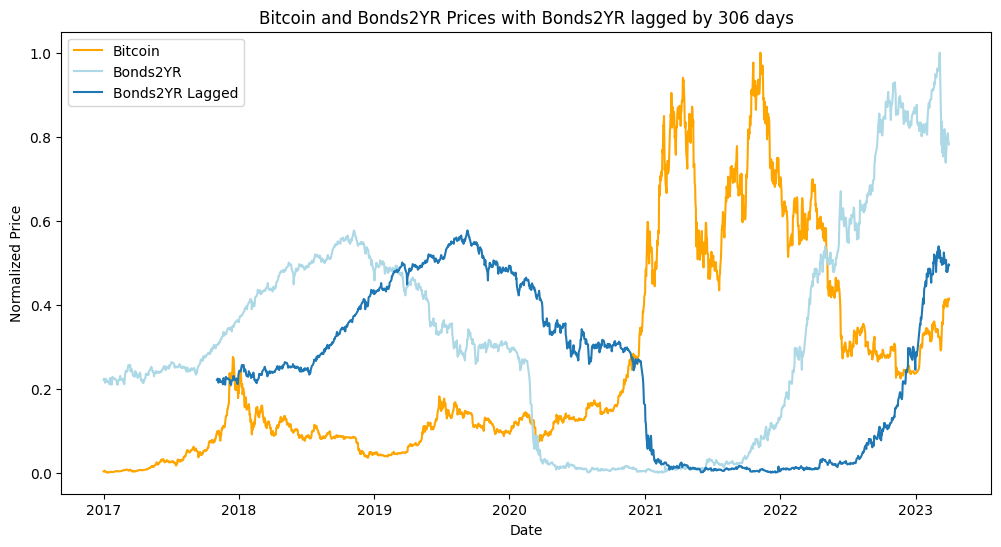

Max correlation with CentralBanks_Liquidity is at lag 0 with correlation 0.873


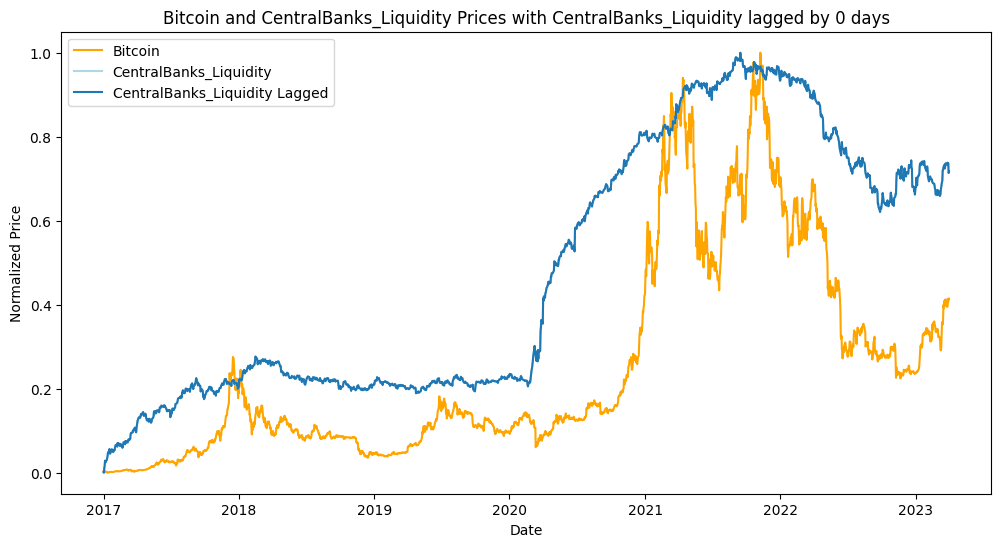

Max correlation with FED_Liquidity is at lag 0 with correlation 0.852


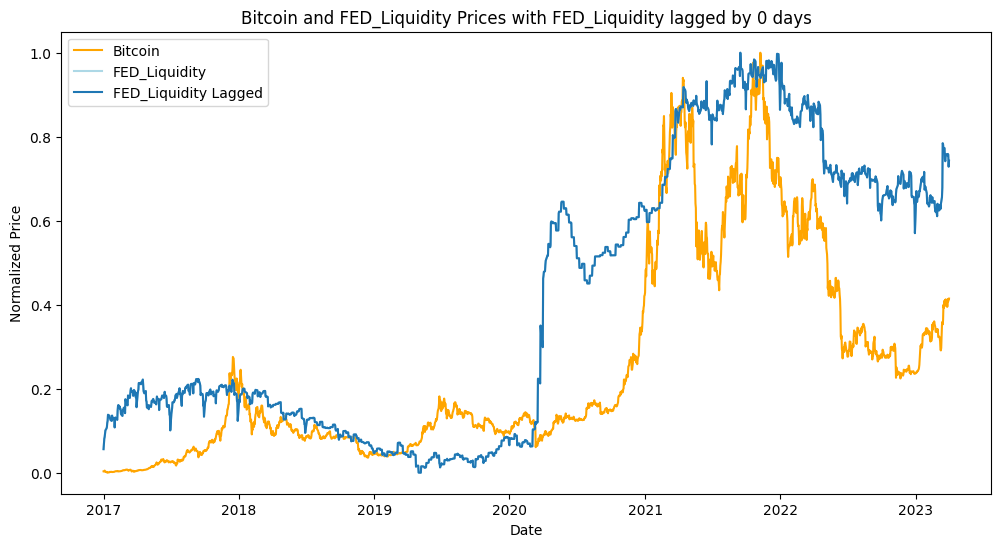

Max correlation with Gold is at lag 0 with correlation 0.681


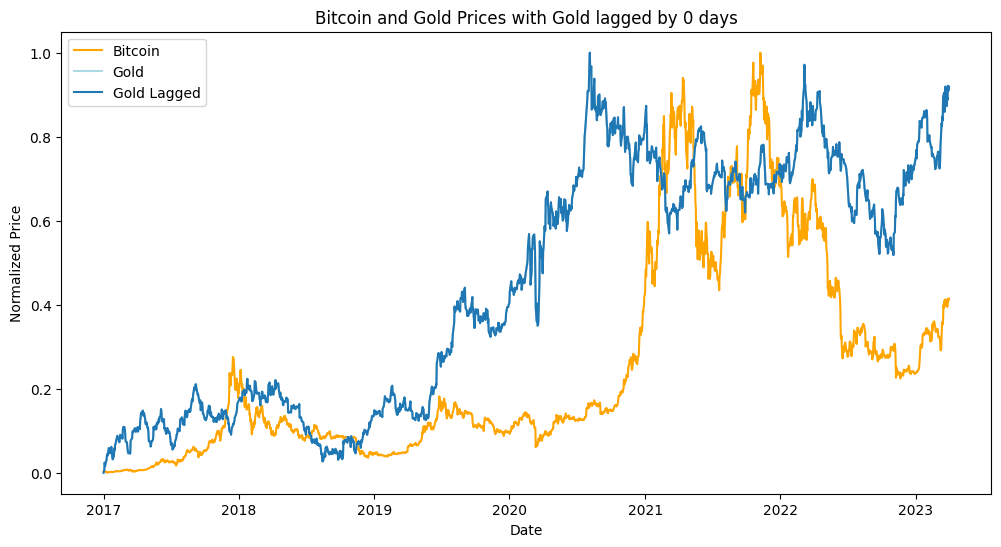

Max correlation with NASDAQ is at lag 0 with correlation 0.905


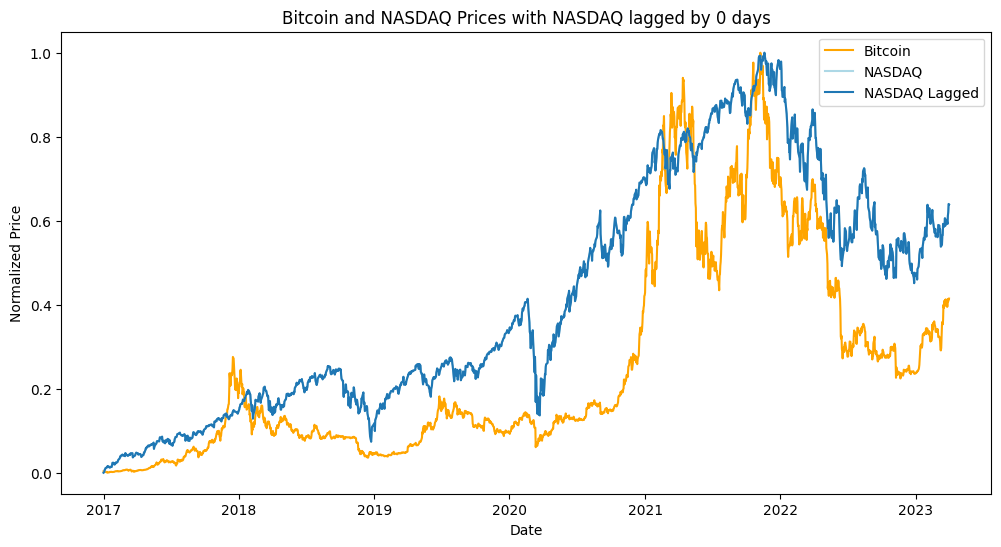

Max correlation with S&P500 is at lag 0 with correlation 0.885


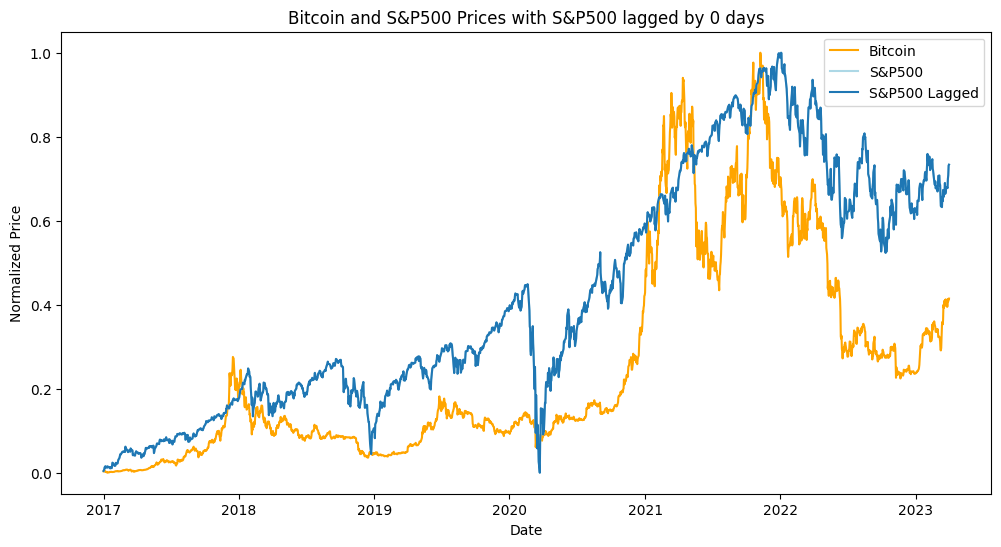

Max correlation with TIPS is at lag 0 with correlation 0.833


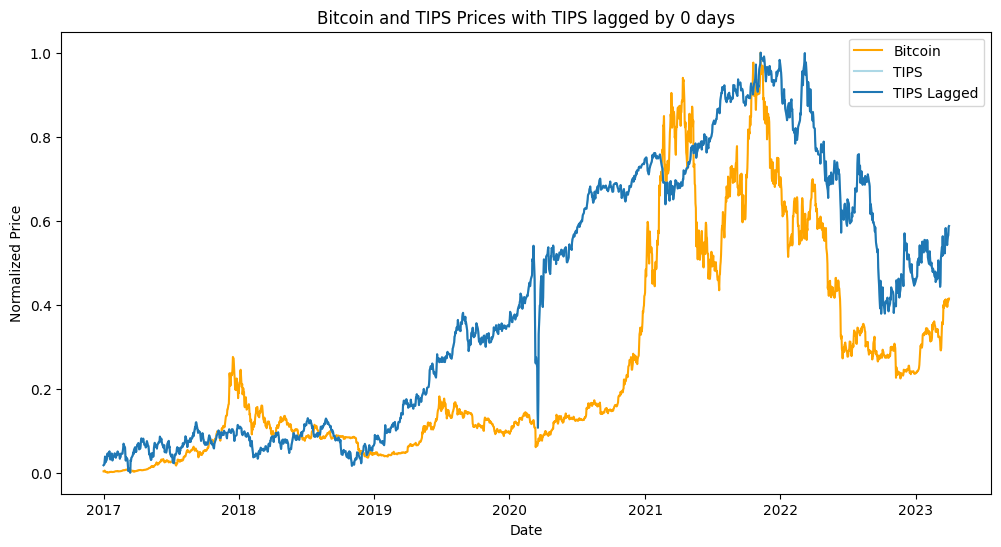

Max correlation with USDollar is at lag 0 with correlation -0.131


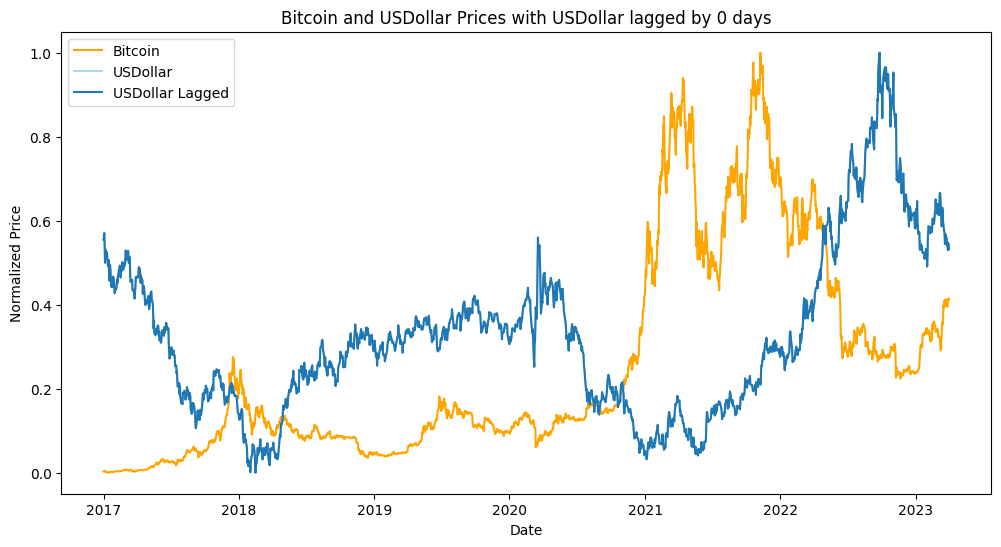

Max correlation with USPS is at lag 340 with correlation 0.731


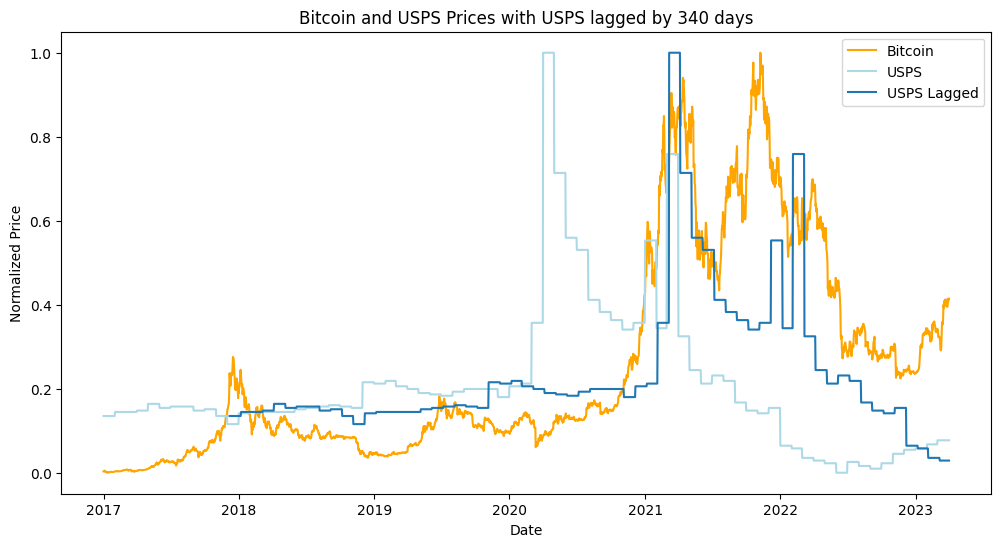

Max correlation with VVIX is at lag 0 with correlation 0.373


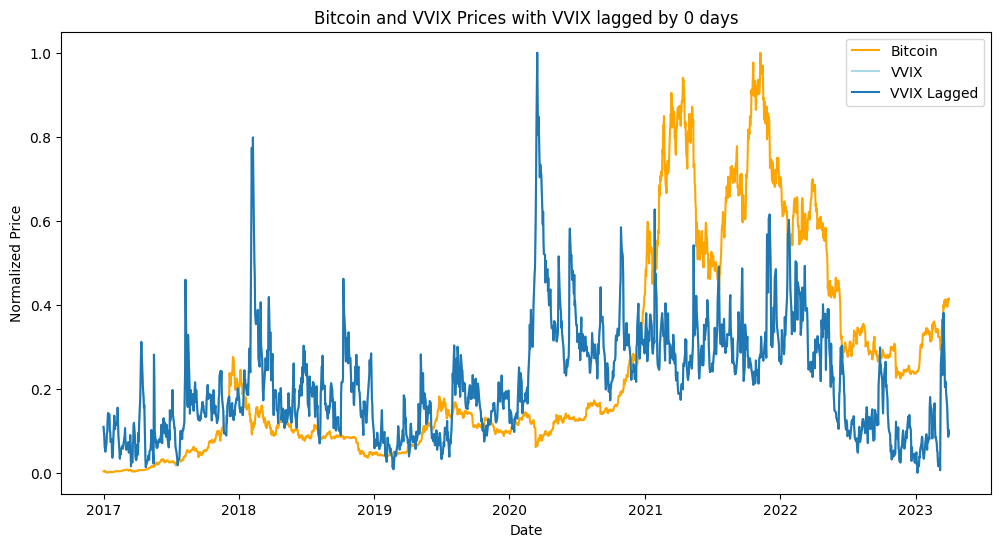

Max correlation with CPI is at lag 0 with correlation 0.561


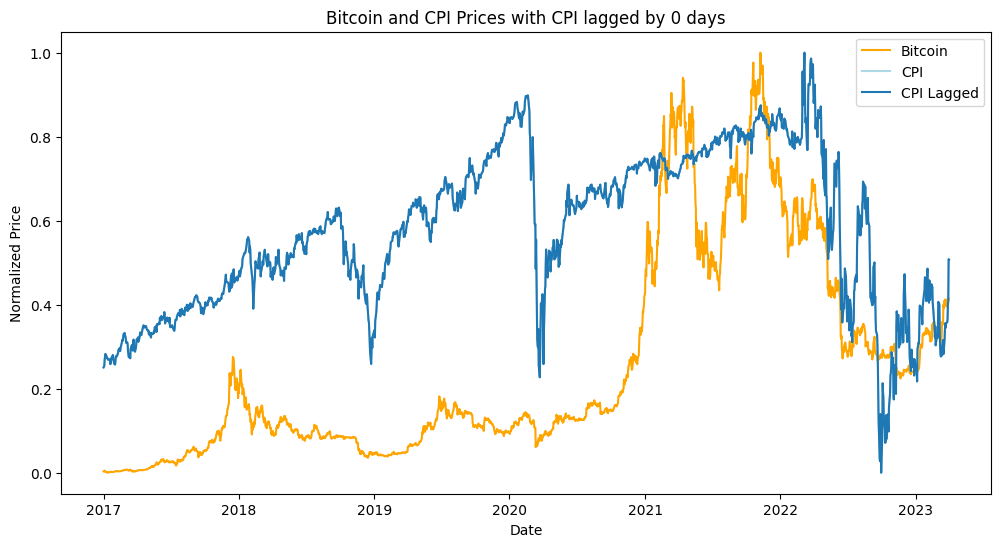

Max correlation with ConsumerSentiment is at lag 0 with correlation -0.574


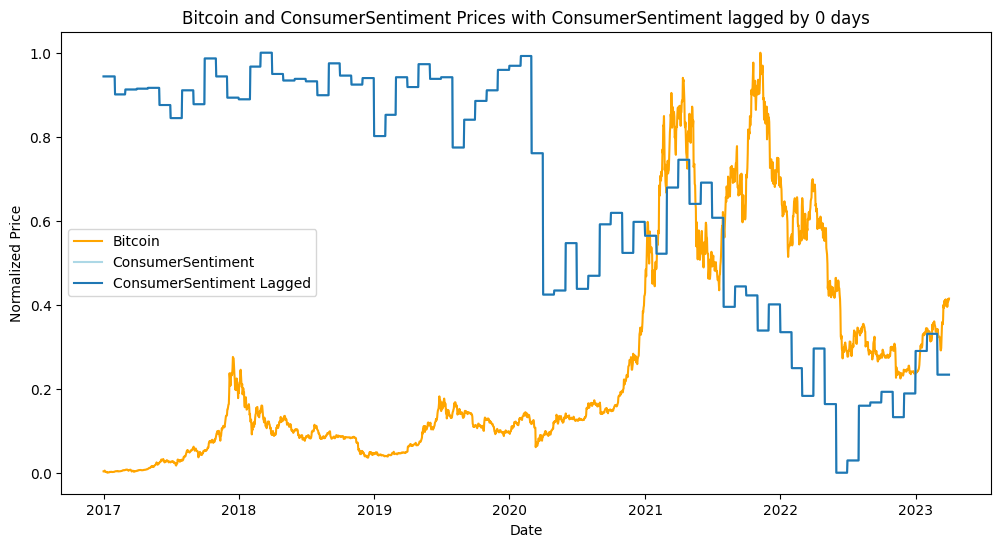

Max correlation with ConsumerSpending is at lag 217 with correlation 0.423


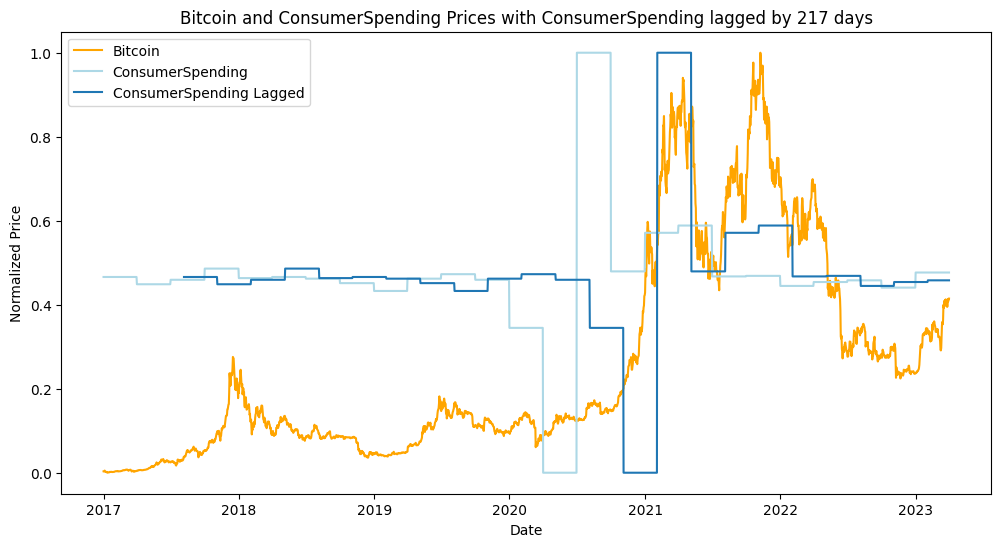

Max correlation with Unemployment is at lag 313 with correlation 0.748


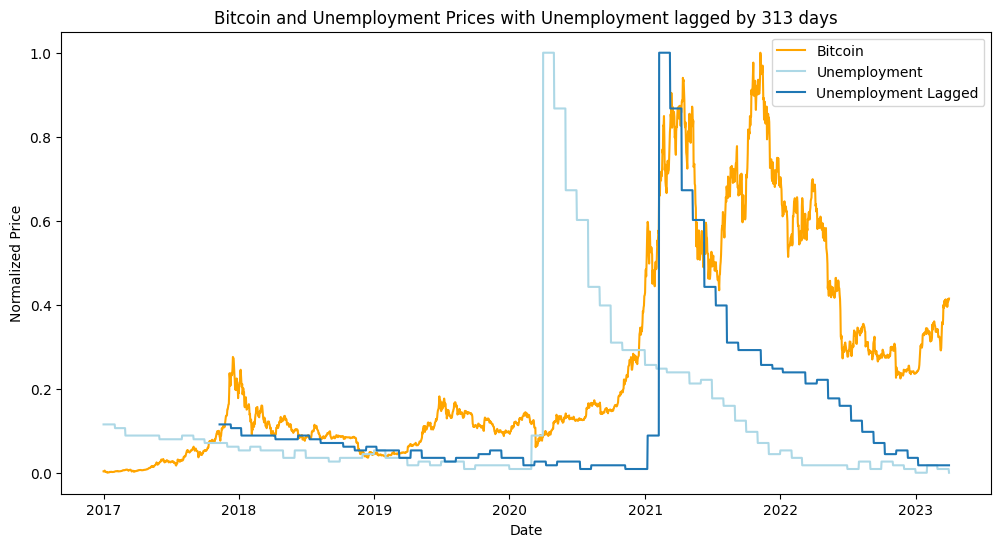

Max correlation with PCE is at lag 0 with correlation 0.642


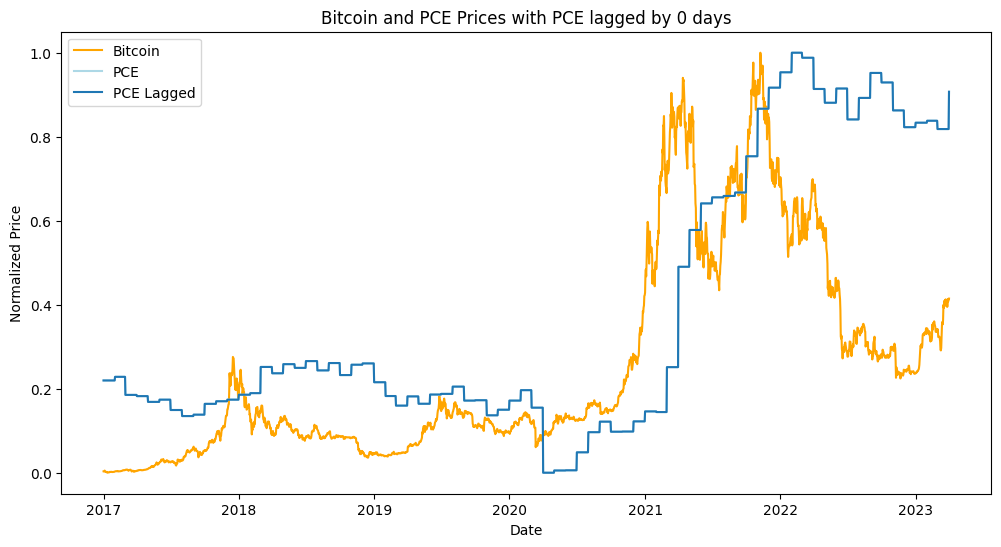

In [22]:
# Print and plot data and correlations for each factor
for factor in correlations.index:
  if factor in lag_factors:
    # Calculate and print correlation with potential time lags
    lag = range(0, 366) # Until 365 days
    lag_corr = [bitcoin_data_scaled['bitcoin'].corr(bitcoin_data_scaled[factor].shift(i)) for i in lag]

    # Find the index of the maximum correlation
    max_lag = np.argmax(np.abs(lag_corr))

    # Save the maximum absolute correlation and the lag to the dictionary
    max_correlations[factor] = lag_corr[max_lag]
    max_correlations_lags[factor] = max_lag

  else:
    # If factor is not in interested_factors, calculate correlation without lag
    max_lag = 0
    max_correlations[factor] = bitcoin_data_scaled['bitcoin'].corr(bitcoin_data_scaled[factor])
    max_correlations_lags[factor] = max_lag

  # Print the maximum correlation and the corresponding lag
  print('Max correlation with', factor, 'is at lag %s with correlation %.3f' % (max_lag, max_correlations[factor]))

  # Plot Bitcoin and factor prices
  plt.figure(figsize=(12, 6))
  plt.plot(bitcoin_data_scaled['bitcoin'], label='Bitcoin', color='orange')
  plt.plot(bitcoin_data_scaled[factor], label=factor, color='lightblue')
  plt.plot(bitcoin_data_scaled[factor].shift(max_lag), label=f"{factor} Lagged")
  plt.title(f"Bitcoin and {factor} Prices with {factor} lagged by {max_lag} days")
  plt.xlabel('Date')
  plt.ylabel('Normalized Price')
  plt.legend()
  plt.show()

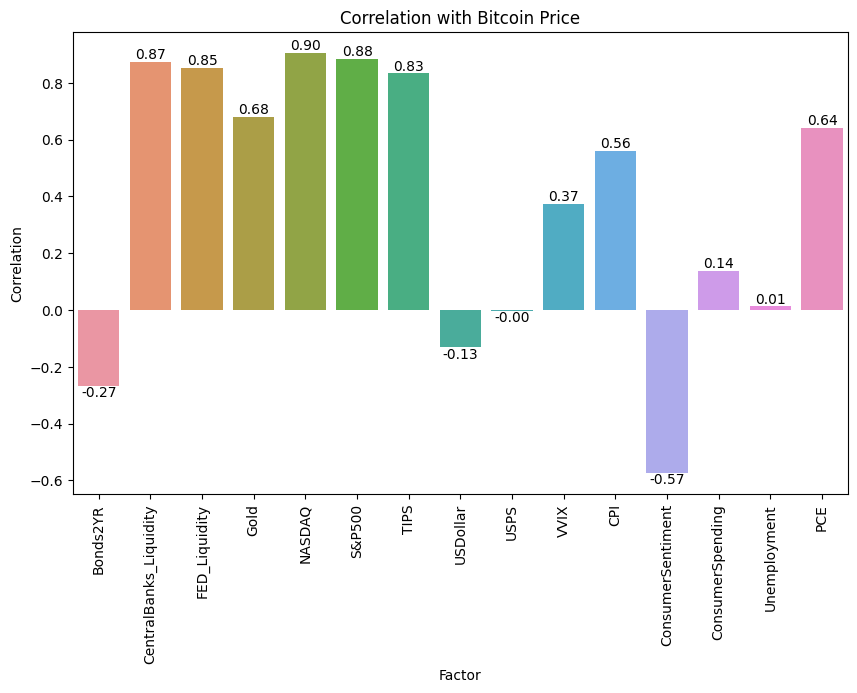

In [23]:
# Plot original correlations
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Correlation with Bitcoin Price')
plt.xlabel('Factor')
plt.xticks(rotation=90)
plt.ylabel('Correlation')

barplot.bar_label(barplot.containers[0], fmt='%.2f')

plt.show()

In [24]:
# Convert the dictionary to a pandas Series for easy plotting
max_correlations_series = pd.Series(max_correlations)

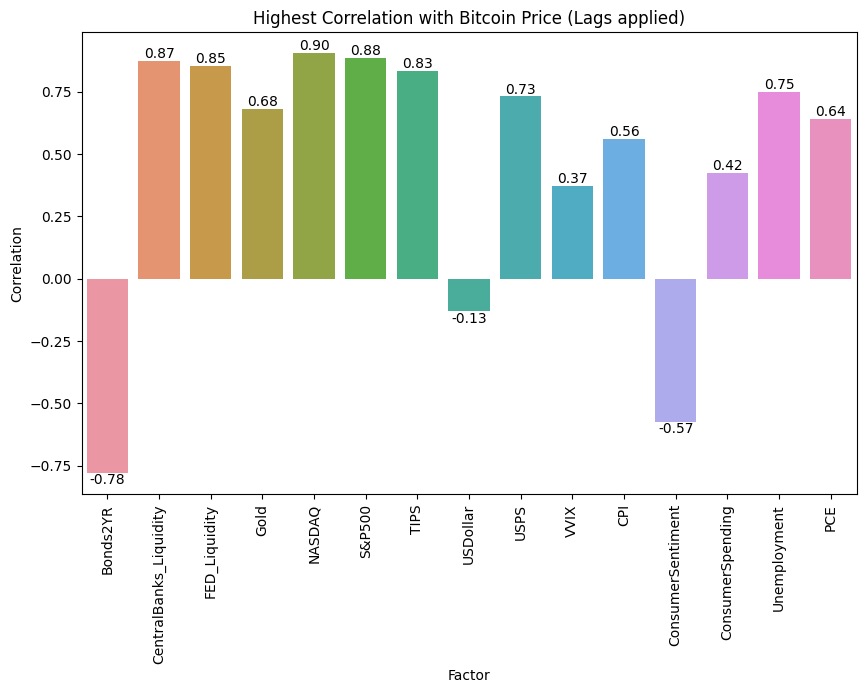

In [25]:
# Plot the highest correlations
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=max_correlations_series.index, y=max_correlations_series.values)
plt.title('Highest Correlation with Bitcoin Price (Lags applied)')
plt.xlabel('Factor')
plt.xticks(rotation=90)
plt.ylabel('Correlation')

barplot.bar_label(barplot.containers[0], fmt='%.2f')

plt.show()

## Multiple Linear Regression Model

In [26]:
# Apply the maximum correlation lags to the data
for factor, lag in max_correlations_lags.items():
    bitcoin_data[factor] = bitcoin_data[factor].shift(lag)

# Drop any rows with missing data that might have been introduced by shifting
bitcoin_data.dropna(inplace=True)

# Get the factors with the strongest correlations
strong_factors = [factor for factor, corr in max_correlations.items() if abs(corr) > 0.5]

# Prepare the data for the linear regression model
X = bitcoin_data[strong_factors]  # explanatory variables
y = bitcoin_data['bitcoin']  # dependent variable


X = sm.add_constant(X)  # add a constant term to the explanatory variables

# Train the model
model = sm.OLS(y, X)
results = model.fit()

print("R-squared: ", results.rsquared)
print("Coefficients: ", results.params)

R-squared:  0.9081020291924056
Coefficients:  const                    -6.578663e+01
Bonds2YR                 -4.358234e+02
CentralBanks_Liquidity   -1.349405e-09
FED_Liquidity             3.535096e-09
Gold                     -1.092278e+01
NASDAQ                    4.160560e+00
S&P500                    2.929532e+00
TIPS                      1.902450e+02
USPS                      2.390380e+02
CPI                      -1.969858e+03
ConsumerSentiment         9.039812e+01
Unemployment              1.912906e+03
PCE                       7.590505e+02
dtype: float64


In [27]:
def predict_bitcoin_price(row):
    # Coefficients from the OLS regression results
    coef = {
        'const': -65.7866,
        'Bonds2YR': -435.8234,
        'CentralBanks_Liquidity': -1.349e-09,
        'FED_Liquidity': 3.535e-09,
        'Gold': -10.9228,
        'NASDAQ': 4.1606,
        'S&P500': 2.9295,
        'TIPS': 190.2450,
        'USPS': 239.0380,
        'CPI': -1969.8576,
        'ConsumerSentiment': 90.3981,
        'Unemployment': 1912.9059,
        'PCE': 759.0505
    }

    # Prediction formula
    bitcoin_price_prediction = (
        coef['const'] +
        coef['Bonds2YR'] * row['Bonds2YR'] +
        coef['CentralBanks_Liquidity'] * row['CentralBanks_Liquidity'] +
        coef['FED_Liquidity'] * row['FED_Liquidity'] +
        coef['Gold'] * row['Gold'] +
        coef['NASDAQ'] * row['NASDAQ'] +
        coef['S&P500'] * row['S&P500'] +
        coef['TIPS'] * row['TIPS'] +
        coef['USPS'] * row['USPS'] +
        coef['CPI'] * row['CPI'] +
        coef['ConsumerSentiment'] * row['ConsumerSentiment'] +
        coef['Unemployment'] * row['Unemployment'] +
        coef['PCE'] * row['PCE']
    )

    return bitcoin_price_prediction

In [28]:
# Apply the prediction function to each row in the data
bitcoin_data['predicted_bitcoin'] = bitcoin_data.apply(predict_bitcoin_price, axis=1)

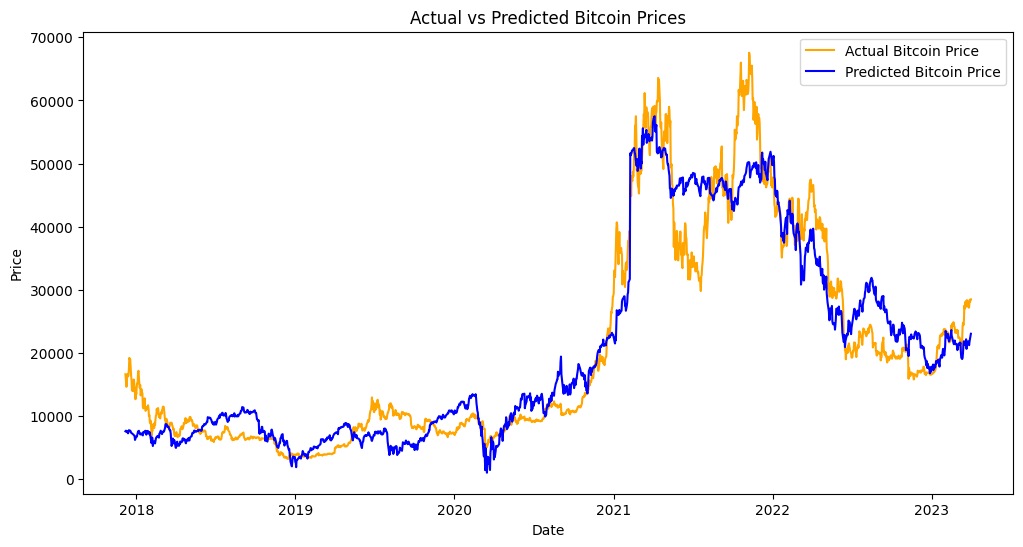

In [29]:
# Plot the actual and predicted Bitcoin prices
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data.index, bitcoin_data['bitcoin'], label='Actual Bitcoin Price', color='orange')
plt.plot(bitcoin_data.index, bitcoin_data['predicted_bitcoin'], label='Predicted Bitcoin Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.legend()
plt.show()

## Random Forest Regression Model

In [30]:
# Create a copy of bitcoin_data to avoid inplace changes
bitcoin_data_rf = bitcoin_data.copy()

# Get the factors with the strongest correlations
strong_factors_rf = [factor for factor, corr in max_correlations.items() if abs(corr) > 0.5]

# Prepare the data for the Random Forest model
X_rf = bitcoin_data_rf[strong_factors_rf]  # explanatory variables
y_rf = bitcoin_data_rf['bitcoin']  # dependent variable

In [31]:
# Do this with new data changes for a new GridSearch

# # Create a Random Forest Regressor
# rf = RandomForestRegressor(n_estimators=100, random_state=1)

# # Hyperparameter tuning with Grid Search
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# #grid_search.fit(X_train_rf, y_train_rf)
# grid_search.fit(X_rf, y_rf)
# best_params = grid_search.best_params_

# print(f"Number of trees in the best model: {best_params['n_estimators']}")
# print(f"Maximum depth in the best model: {best_params['max_depth']}")
# print(f"Minimum number of samples required to split an internal node: {best_params['min_samples_split']}")
# print(f"Minimum number of samples required to be at a leaf node: {best_params['min_samples_leaf']}")

In [32]:
# Create a new Random Forest Regressor using the best parameters
#best_rf = RandomForestRegressor(**best_params, random_state=1) # Use when new Gridsearch is performed
best_rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=1)

# Train the model using the entire dataset
best_rf.fit(X_rf, y_rf)

# R-squared for the train data
r2_train_rf = best_rf.score(X_rf, y_rf)
print(f"R-squared for train data: {r2_train_rf}")

R-squared for train data: 0.9967017649056185


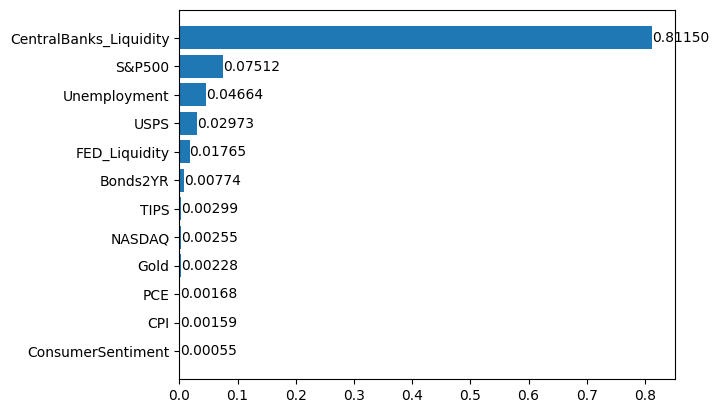

In [33]:
# Feature importance inspection
importances_rf = best_rf.feature_importances_
importances_series_rf = pd.Series(importances_rf, index=X_rf.columns).sort_values()

# Plot
fig, ax = plt.subplots()
bars = ax.barh(importances_series_rf.index, importances_series_rf.values)

# Add value labels to each bar
ax.bar_label(bars, fmt='%.5f')

plt.show()

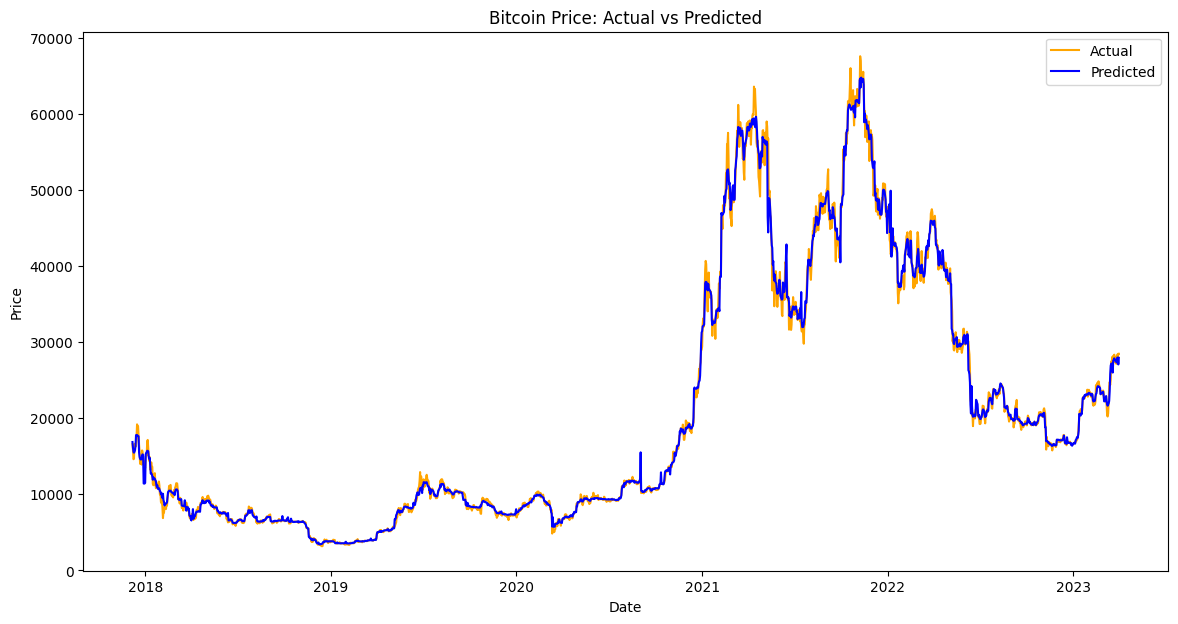

In [34]:
# Make predictions using the entire dataset
bitcoin_data_rf['Predicted'] = best_rf.predict(bitcoin_data_rf[strong_factors_rf])

# Plot actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(bitcoin_data_rf.index, bitcoin_data_rf['bitcoin'], label='Actual', color = 'orange')
plt.plot(bitcoin_data_rf.index, bitcoin_data_rf['Predicted'], label='Predicted', color='blue')
plt.title('Bitcoin Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Model Testing and Comparison

In [35]:
# Easy function to find difference of days
def subtract_days(date, num_days):
    # Convert the date string to a datetime object using strptime (string parse time).
    date = datetime.strptime(date, "%Y-%m-%d")

    # Subtract the number of days from the date using a timedelta object (difference between two dates or times)
    result_date = date - timedelta(days=num_days)

    # Convert the resulting datetime object back to a string in the format "YYYY-MM-DD" using strftime (string format time).
    return result_date.strftime("%Y-%m-%d")

In [36]:
# Calculate day
date = "2024-01-01"
num_days = 340

print(subtract_days(date, num_days))

2023-01-26


In [37]:
# May 1st 2023

actual_value_1 = 27915

future_Bonds2YR = 2.957 # Subtract 306 days - June 29th 2022
future_CentralBanks_Liquidity = 19881819024360
future_FED_Liquidity = 6031200000000
future_Gold = 1992.2
future_NASDAQ = 12212.5979
future_S_P500 = 4167.88
future_TIPS = 108.39
future_USPS = 3.4 # Subtract 340 days - May 26th 2022
future_CPI = 25.1266
future_ConsumerSentiment = 63.5
future_Unemployment = 3.6 # Subtract 313 days - June 22nd 2022
future_PCE = 5


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})


# Predict the future Bitcoin price using the trained MLR model
bitcoin_price_prediction = predict_bitcoin_price(future_values.iloc[0])
print("Predicted Bitcoin price for May 1st using MLR Model:", bitcoin_price_prediction)

# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted Bitcoin price for May 1st using RFR Model: {future_bitcoin_price[0]}")

print("Actual Bitcoin price for May 1st:", actual_value_1)

# Save values for later
pred1_mlr = bitcoin_price_prediction
pred1_rf = future_bitcoin_price[0]

Predicted Bitcoin price for May 1st using MLR Model: 22765.892732918357
Predicted Bitcoin price for May 1st using RFR Model: 24707.381961578456
Actual Bitcoin price for May 1st: 27915


In [38]:
# May 5th 2023

actual_value_2 = 29547

future_Bonds2YR = 2.8875 # Subtract 306 days - July 3rd 2022
future_CentralBanks_Liquidity = 20017187395880
future_FED_Liquidity = 6027363000000
future_Gold = 2024.8
future_NASDAQ = 12235.4128
future_S_P500 = 4136.26
future_TIPS = 109.46
future_USPS = 3.4 # Subtract 340 days - May 30th 2022
future_CPI = 25.04
future_ConsumerSentiment = 63.5
future_Unemployment = 3.6 # Subtract 313 days - June 26th 2022
future_PCE = 5


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})



# Predict the future Bitcoin price using the trained MLR model
bitcoin_price_prediction = predict_bitcoin_price(future_values.iloc[0])
print("Predicted Bitcoin price for May 5th using MLR Model:", bitcoin_price_prediction)

# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted Bitcoin price for May 5th using RFR Model: {future_bitcoin_price[0]}")

print("Actual Bitcoin price for May 5th:", actual_value_2)

# Save values for later
pred2_mlr = bitcoin_price_prediction
pred2_rf = future_bitcoin_price[0]

Predicted Bitcoin price for May 5th using MLR Model: 22620.368152137882
Predicted Bitcoin price for May 5th using RFR Model: 24699.9241184412
Actual Bitcoin price for May 5th: 29547


In [39]:
# May 10th 2023

actual_value_3 = 27400

future_Bonds2YR = 3.111 # Subtract 306 days - July 8th 2022
future_CentralBanks_Liquidity = 20053964343190
future_FED_Liquidity = 6072202000000
future_Gold = 2037.1
future_NASDAQ = 12306.4418
future_S_P500 = 4137.63
future_TIPS = 109
future_USPS = 2.7 # Subtract 340 days - June 4th 2022
future_CPI = 25.04
future_ConsumerSentiment = 63.5
future_Unemployment = 3.5 # Subtract 313 days - July 1st 2022
future_PCE = 5


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})



# Predict the future Bitcoin price using the trained MLR model
bitcoin_price_prediction = predict_bitcoin_price(future_values.iloc[0])
print("Predicted Bitcoin price for May 10th using MLR Model:", bitcoin_price_prediction)

# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted Bitcoin price for May 10th using RFR Model: {future_bitcoin_price[0]}")

print("Actual Bitcoin price for May 10th:", actual_value_3)

# Save values for later
pred3_mlr = bitcoin_price_prediction
pred3_rf = future_bitcoin_price[0]

Predicted Bitcoin price for May 10th using MLR Model: 22350.911727716695
Predicted Bitcoin price for May 10th using RFR Model: 24705.560506366608
Actual Bitcoin price for May 10th: 27400


In [40]:
# May 15th 2023

actual_value_4 = 27475

future_Bonds2YR = 3.138 # Subtract 306 days - July 13th 2022
future_CentralBanks_Liquidity = 19924316306100
future_FED_Liquidity = 6084424000000
future_Gold = 2022.7
future_NASDAQ = 12365.2094
future_S_P500 = 4136.27
future_TIPS = 108.89
future_USPS = 2.7 # Subtract 340 days - june 9th 2022
future_CPI = 24.97
future_ConsumerSentiment = 63.5
future_Unemployment = 3.5 # Subtract 313 days - July 6th 2022
future_PCE = 5


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})



# Predict the future Bitcoin price using the trained MLR model
bitcoin_price_prediction = predict_bitcoin_price(future_values.iloc[0])
print("Predicted Bitcoin price for May 15th using MLR Model:", bitcoin_price_prediction)

# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted Bitcoin price for May 15th using RFR Model: {future_bitcoin_price[0]}")

print("Actual Bitcoin price for May 15th:", actual_value_4)

# Save values for later
pred4_mlr = bitcoin_price_prediction
pred4_rf = future_bitcoin_price[0]

Predicted Bitcoin price for May 15th using MLR Model: 23072.020226511093
Predicted Bitcoin price for May 15th using RFR Model: 24688.460427973172
Actual Bitcoin price for May 15th: 27475


In [41]:
# May 22nd 2023

actual_value_5 = 26865

future_Bonds2YR = 3.089 # Subtract 306 days - July 10th 2022
future_CentralBanks_Liquidity = 19761485450120
future_FED_Liquidity = 6065229000000
future_Gold = 1977.2
future_NASDAQ = 12720.7762
future_S_P500 = 4192.62
future_TIPS = 107.79
future_USPS = 2.7 # Subtract 340 days - June 16th 2022
future_CPI = 24.96
future_ConsumerSentiment = 63.5
future_Unemployment = 3.5 # Subtract 313 days - July 13th 2022
future_PCE = 5


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})



# Predict the future Bitcoin price using the trained MLR model
bitcoin_price_prediction = predict_bitcoin_price(future_values.iloc[0])
print("Predicted Bitcoin price for May 22nd using MLR Model:", bitcoin_price_prediction)

# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted Bitcoin price for May 22nd using RFR Model: {future_bitcoin_price[0]}")

print("Actual Bitcoin price for May 22nd:", actual_value_5)

# Save values for later
pred5_mlr = bitcoin_price_prediction
pred5_rf = future_bitcoin_price[0]

Predicted Bitcoin price for May 22nd using MLR Model: 25197.045101908116
Predicted Bitcoin price for May 22nd using RFR Model: 24648.072660720813
Actual Bitcoin price for May 22nd: 26865


In [42]:
# May 30th 2023

actual_value_6 = 28000

future_Bonds2YR = 2.888 # Subtract 306 days - July 28th de 2022
future_CentralBanks_Liquidity = 19746077932960
future_FED_Liquidity = 6173824000000
future_Gold = 1977.5
future_NASDAQ = 13017.4256
future_S_P500 = 4205.53
future_TIPS = 107.85
future_USPS = 2.7 # Subtract 340 days - June 24th 2022
future_CPI = 24.89
future_ConsumerSentiment = 63.5
future_Unemployment = 3.5 # Subtract 313 days - July 21st 2022
future_PCE = 5


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})



# Predict the future Bitcoin price using the trained MLR model
bitcoin_price_prediction = predict_bitcoin_price(future_values.iloc[0])
print("Predicted Bitcoin price for May 30th using MLR Model:", bitcoin_price_prediction)

# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted Bitcoin price for May 30th using RFR Model: {future_bitcoin_price[0]}")

print("Actual Bitcoin price for May 30th:", actual_value_6)

# Save values for later
pred6_mlr = bitcoin_price_prediction
pred6_rf = future_bitcoin_price[0]

Predicted Bitcoin price for May 30th using MLR Model: 27107.40090159695
Predicted Bitcoin price for May 30th using RFR Model: 27712.32675222081
Actual Bitcoin price for May 30th: 28000


In [43]:
# Predicted values from MLR model
predictions_mlr = np.array([pred1_mlr, pred2_mlr, pred3_mlr, pred4_mlr, pred5_mlr, pred6_mlr])

# Predicted values from Random Forest model
predictions_rf = np.array([pred1_rf, pred2_rf, pred3_rf, pred4_rf, pred5_rf, pred6_rf])

# Actual values
actual_values = np.array([actual_value_1, actual_value_2, actual_value_3, actual_value_4, actual_value_5, actual_value_6])

In [44]:
# Calculate RMSE (Root Mean Square Error)
rmse_mlr = mean_squared_error(actual_values, predictions_mlr, squared=False)
rmse_rf = mean_squared_error(actual_values, predictions_rf, squared=False)

print("RMSE for MLR model:", rmse_mlr)
print("RMSE for Random Forest model:", rmse_rf)

RMSE for MLR model: 4526.769715874125
RMSE for Random Forest model: 2994.586442745488


In [45]:
# Calculate MAPE (Mean Absolute Percentage Error)
mape_mlr = mean_absolute_percentage_error(actual_values, predictions_mlr) * 100
mape_rf = mean_absolute_percentage_error(actual_values, predictions_rf) * 100

print("MAPE for MLR model:", mape_mlr)
print("MAPE for Random Forest model:", mape_rf)

MAPE for MLR model: 14.2896107557166
MAPE for Random Forest model: 9.525101597218454


## Projections

In [46]:
# July 4th 2023

future_Bonds2YR = 3.393 # Subtract 306 days - September 1st 2022
future_CentralBanks_Liquidity = 19581359220000
future_FED_Liquidity = 6106428967000
future_Gold = 2200
future_NASDAQ = 13500
future_S_P500 = 4250
future_TIPS = 110
future_USPS = 3.5 # Subtract 340 days - July 29th 2022
future_CPI = 25.20
future_ConsumerSentiment = 56
future_Unemployment = 3.7 # Subtract 313 days - August 25th 2022
future_PCE = 4.3


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})


# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted bitcoin price for July 4th using the RFR Model: {future_bitcoin_price[0]}")

Predicted bitcoin price for July 4th using the RFR Model: 25437.62374380113


In [47]:
# October 1st 2023

future_Bonds2YR = 4.314 # Subtract 306 days - November 29th 2022
future_CentralBanks_Liquidity = 19369880540000
future_FED_Liquidity = 6040479534000
future_Gold = 2850
future_NASDAQ = 12000
future_S_P500 = 4000
future_TIPS = 120
future_USPS = 3.4 # Restar 340 dies - October 26th 2022
future_CPI = 25.12
future_ConsumerSentiment = 57
future_Unemployment = 3.6 # Restar 313 dies - November 22nd 2022
future_PCE = 3.8


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})


# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted bitcoin price for October 1st using the RFR Model: {future_bitcoin_price[0]}")

Predicted bitcoin price for October 1st using the RFR Model: 24523.20500590341


In [48]:
# January 1st 2024

future_Bonds2YR = 4.891 # Subtract 306 days - March 1st 2023
future_CentralBanks_Liquidity = 18782973160000
future_FED_Liquidity = 5857453004000
future_Gold = 3100
future_NASDAQ = 10500
future_S_P500 = 3000
future_TIPS = 130
future_USPS = 4.5 # Subtract 340 days - January 26th 2023
future_CPI = 25.12
future_ConsumerSentiment = 60
future_Unemployment = 3.6 # Subtract 313 days - February 22nd 2023
future_PCE = 3.2


# Create a DataFrame for the future values
future_values = pd.DataFrame({
    'Bonds2YR': [future_Bonds2YR],
    'CentralBanks_Liquidity': [future_CentralBanks_Liquidity],
    'FED_Liquidity': [future_FED_Liquidity],
    'Gold': [future_Gold],
    'NASDAQ': [future_NASDAQ],
    'S&P500': [future_S_P500],
    'TIPS': [future_TIPS],
    'USPS': [future_USPS],
    'CPI': [future_CPI],
    'ConsumerSentiment': [future_ConsumerSentiment],
    'Unemployment': [future_Unemployment],
    'PCE': [future_PCE],
})


# Predict the future bitcoin price using the trained Random Forest model
future_bitcoin_price = best_rf.predict(future_values)
print(f"Predicted bitcoin price for January 1st 2024 using the RFR Model: {future_bitcoin_price[0]}")

Predicted bitcoin price for January 1st 2024 using the RFR Model: 9736.414648980735
